In [216]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import norm
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

In [217]:
def importdata(tickers,start="2020-01-01",end="2022-01-31"):
    data = yf.download(tickers, 
                       start = start, end = end, 
                       progress= False)['Adj Close']
    return(data)

###Example: 
data = importdata(["MSFT","AAPL"])
data.head()

,AAPL,MSFT
Date,,
2020-01-02,73.152657,154.779541
2020-01-03,72.441467,152.852219
2020-01-06,73.018677,153.247330
2020-01-07,72.675278,151.850098
2020-01-08,73.844330,154.268784


In [218]:
def stock_capm(stktck,mkttck = "^GSPC", 
               start = '2010-1-1', 
               end = datetime.today().strftime('%Y-%m-%d'),
               rf = 0.025,annfactor = 250):
    
    tcklist=[]
    for i in [mkttck, stktck]:
        if isinstance(i, list):
            tcklist += i
        else:
            tcklist.append(i)

    data = importdata(tcklist)
    
    logrtn = np.log(1+data.pct_change().dropna())
    covmatrix = logrtn.cov()*annfactor
    cov_w_market = pd.DataFrame(covmatrix.iloc[:-1,-1])
    market_var = logrtn[mkttck].var()*annfactor
    beta = cov_w_market / market_var
    stdev_ret = pd.DataFrame(((logrtn.std()*annfactor**0.5)[:-1]), columns=['STD'])
    beta = beta.merge(stdev_ret, left_index=True, right_index=True)

    for i, row in beta.iterrows():
        beta.at[i,'CAPM'] = rf + (row[mkttck] * (logrtn[mkttck].mean()-rf))
    # Sharpe
    for i, row in beta.iterrows():
        beta.at[i,'Sharpe'] = ((row['CAPM']-rf)/(row['STD']))
    beta.rename(columns={"^GSPC":"Beta"}, inplace=True)
    
    return beta

In [219]:
stock_capm(["AAPL","IBM"])

,Beta,STD,CAPM,Sharpe
AAPL,1.150914,0.371895,-0.003096,-0.075547
IBM,0.912378,0.330509,0.002727,-0.067389


In [220]:
def logreturns(price):
    df = np.log(1 + price.pct_change().dropna())
    return(df)

###Example: 
logreturn = logreturns(data)
logreturn

,AAPL,MSFT
Date,,
2020-01-03,-0.009770,-0.012530
2020-01-06,0.007936,0.002582
2020-01-07,-0.004714,-0.009159
2020-01-08,0.015958,0.015803
2020-01-09,0.021019,0.012416
...,...,...
2022-01-24,-0.004876,0.001148
2022-01-25,-0.011450,-0.026948
2022-01-26,-0.000564,0.028095


In [221]:
def drift_calc(data):
    logreturn = logreturns(data)
    mu = logreturn.mean()
    sigma = logreturn.std()
    drift = mu - 0.5*sigma**2
    return(drift)

In [222]:
def daily_rtns(data,days,iterations):
    drift = drift_calc(data)
    logreturn = logreturns(data)
    sigma = logreturn.std()
    daily_rtn =np.exp(drift + sigma * norm.ppf(np.random.rand(days, iterations)))
    return(daily_rtn)

In [223]:
def simulate_mc(data, days, iterations, plot=True):
    # Generate daily returns
    returns = daily_rtns(data, days, iterations)
    # Create empty matrix
    price_list = np.zeros_like(returns)
    # Put the last actual price in the first row of matrix. 
    price_list[0] = data.iloc[-1]
    # Calculate the price of each day
    for t in range(1,days):
        price_list[t] = price_list[t-1]*returns[t]
    
    # Plot Option
    if plot == True:
        x = pd.DataFrame(price_list).iloc[-1]
        fig, ax = plt.subplots(1,2, figsize=(14,4))
        sns.histplot(x, kde=True, stat="density", ax=ax[0])
        sns.histplot(x, kde=True, stat="density", cumulative=True,kde_kws={'cumulative':True},ax=ax[1])
        plt.xlabel("Stock Price")
        plt.show()
          
    return pd.DataFrame(price_list)

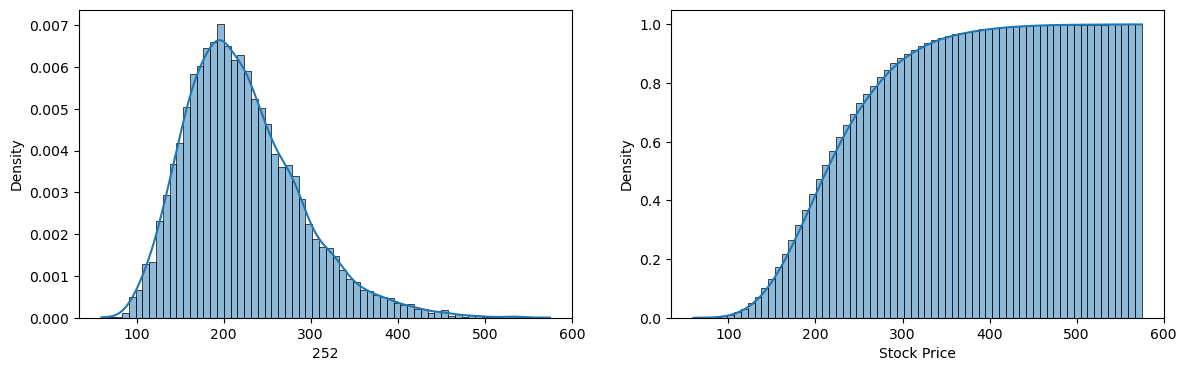

Beta: 1.15
Sharpe: -0.08
CAPM Return: -0.31%


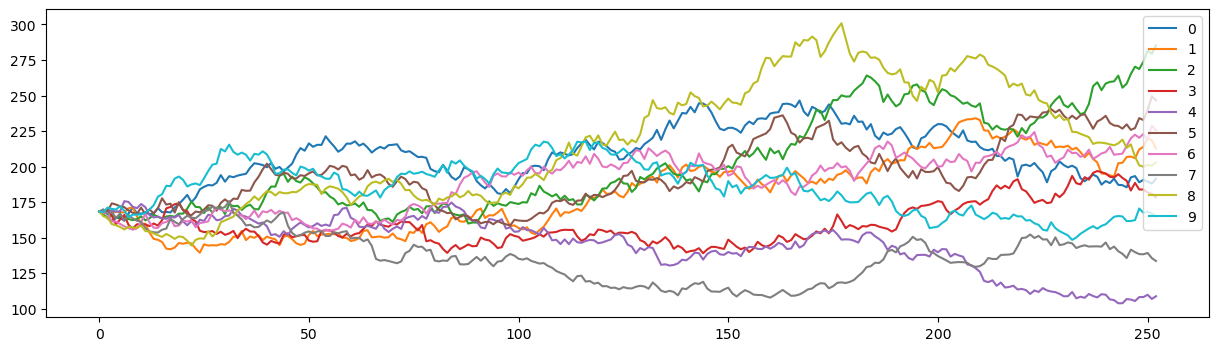

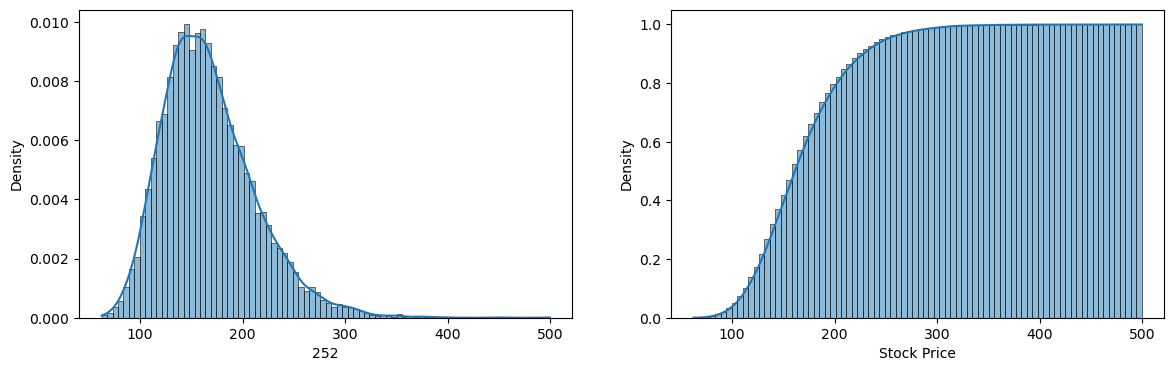

Beta: 0.99
Sharpe: -0.08
CAPM Return: 0.08%


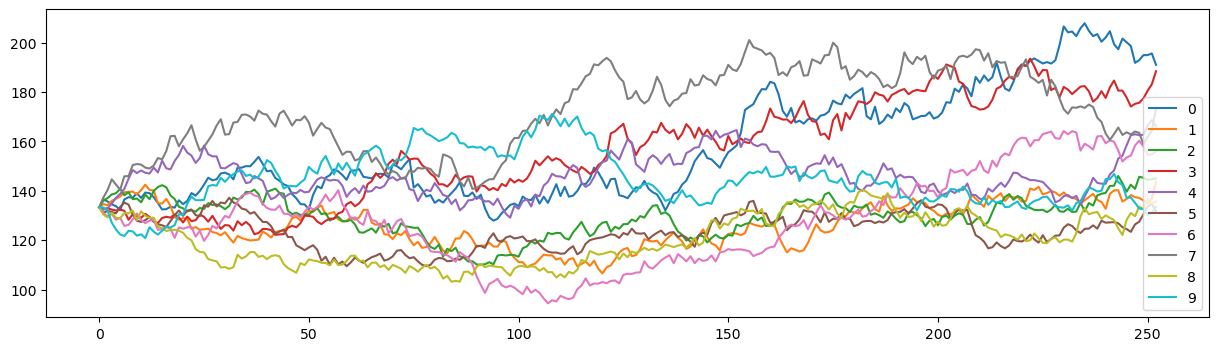

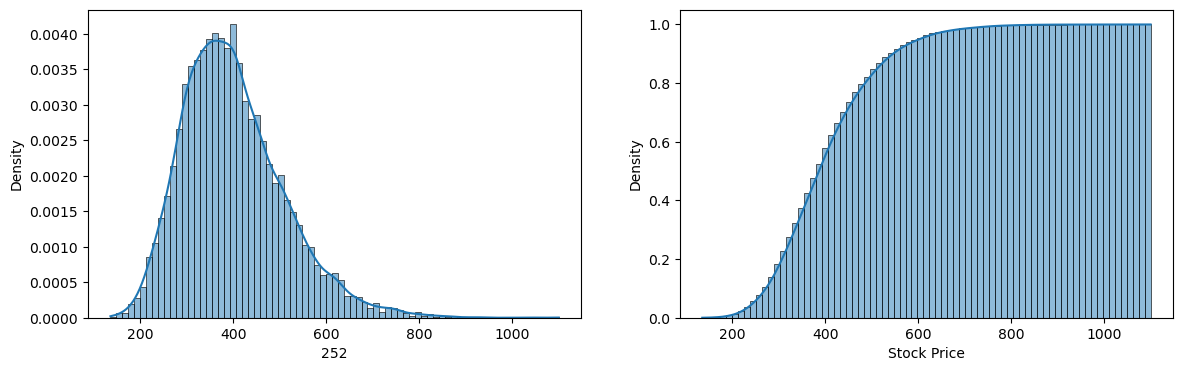

Beta: 1.12
Sharpe: -0.08
CAPM Return: -0.25%


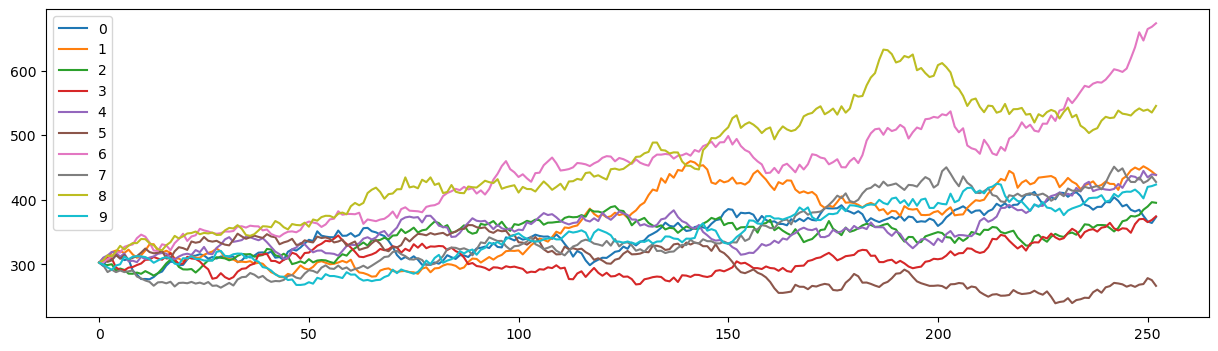

In [224]:
def multistockmonte_carlo(stktck, 
                          days_forecast, iterations, 
                          start_date = '2000-1-1', plotten=False):
    data = importdata(stktck, start=start_date)
    betasharpe = stock_capm(stktck, start=start_date)
    simulatedDF = []
    for t in range(len(stktck)):
        y = simulate_mc(data.iloc[:,t], (days_forecast+1), iterations)
        if plotten == True:
            forplot = y.iloc[:,0:10]
            forplot.plot(figsize=(15,4))
        print(f"Beta: {round(betasharpe.iloc[t,betasharpe.columns.get_loc('Beta')],2)}")
        print(f"Sharpe: {round(betasharpe.iloc[t,betasharpe.columns.get_loc('Sharpe')],2)}") 
        print(f"CAPM Return: {round(100*betasharpe.iloc[t,betasharpe.columns.get_loc('CAPM')],2)}%")
        y['ticker'] = stktck[t]
        cols = y.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        y = y[cols]
        simulatedDF.append(y)
    simulatedDF = pd.concat(simulatedDF)
    return simulatedDF
#Example use

ret_sim_df = multistockmonte_carlo(['GOOG','AAPL','MSFT'],252,10000,
                                   start_date='2015-1-1', plotten=True)